# Image pixel-level saliency using VGG-19 Conv-net

Lets have plots appear inline:

In [1]:
%matplotlib inline

/Users/Geoff/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


We're going to need `numpy`, `matplotlib`, `skimage`, `theano` and `lasagne`. The `pretrained_vgg_models` contains some useful functions for building and acquiring VGG models.

In [2]:
import os, time
import numpy as np
from matplotlib import pyplot as plt
import theano
import theano.tensor as T
import lasagne
import skimage.transform, skimage.util
import pretrained_vgg_models

from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, DropoutLayer, Pool2DLayer, Conv2DLayer, NINLayer
from lasagne.nonlinearities import softmax
from lasagne.utils import floatX


## Load an image to process

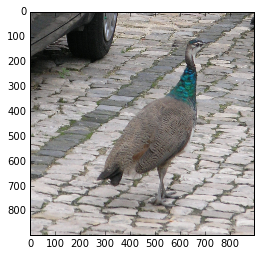

In [3]:
def load_image_block(path, x_pos=None, y_pos=None, width=None, height=None):
    return plt.imread(path)[y_pos:y_pos+height, x_pos:x_pos+width]

def load_image(path):
    return plt.imread(path)

# Extract a 896 x 896 block surrounding the peacock
peacock = load_image_block(os.path.join('images', 'P1013781.JPG'), 652, 1800, 896, 896)
plt.imshow(peacock)
plt.show()

## Load the model

To save some time, we are going to use the `VGG19Model` class from `pretrained_vgg_models` to build the network and load its parameters:

In [4]:
vgg19_model = pretrained_vgg_models.VGG19Model.load()

Create the input variable, generate the probability expression and construct a Theano function that we can call to predict image probability vectors:

In [5]:
in_var = theano.tensor.tensor4('x')
prob = lasagne.layers.get_output(vgg19_model.network['prob'], in_var, deterministic=True)
prob_fn = theano.function([in_var], prob)

## Discover the pixel-level image saliency
We will be using guided backpropagation [1] as described in, with the implementation taken from [2]:

[1]: Springenberg et al. (2015): "Striving for Simplicity - The All Convolutional Net", http://arxiv.org/abs/1412.6806
[2]: Jan Schlüter (@f0k), 2015-10-13: "Saliency Maps and Guided Backpropagation (Lasagne Recipe)", http://github.com/Lasagne/Recipes/blob/master/examples/Saliency%20Maps%20and%20Guided%20Backpropagation.ipynb

Please see the above references for more information on the technique and its implementation.

In [6]:
class ModifiedBackprop(object):
    def __init__(self, nonlinearity):
        self.nonlinearity = nonlinearity
        self.ops = {}  # memoizes an OpFromGraph instance per tensor type

    def __call__(self, x):
        # OpFromGraph is oblique to Theano optimizations, so we need to move
        # things to GPU ourselves if needed.
        if theano.sandbox.cuda.cuda_enabled:
            maybe_to_gpu = theano.sandbox.cuda.as_cuda_ndarray_variable
        else:
            maybe_to_gpu = lambda x: x
        # We move the input to GPU if needed.
        x = maybe_to_gpu(x)
        # We note the tensor type of the input variable to the nonlinearity
        # (mainly dimensionality and dtype); we need to create a fitting Op.
        tensor_type = x.type
        # If we did not create a suitable Op yet, this is the time to do so.
        if tensor_type not in self.ops:
            # For the graph, we create an input variable of the correct type:
            inp = tensor_type()
            # We pass it through the nonlinearity (and move to GPU if needed).
            outp = maybe_to_gpu(self.nonlinearity(inp))
            # Then we fix the forward expression...
            op = theano.OpFromGraph([inp], [outp])
            # ...and replace the gradient with our own (defined in a subclass).
            op.grad = self.grad
            # Finally, we memoize the new Op
            self.ops[tensor_type] = op
        # And apply the memoized Op to the input we got.
        return self.ops[tensor_type](x)
    
class GuidedBackprop(ModifiedBackprop):
    def grad(self, inputs, out_grads):
        (inp,) = inputs
        (grd,) = out_grads
        dtype = inp.dtype
        return (grd * (inp > 0).astype(dtype) * (grd > 0).astype(dtype),)
    
# Only instantiate this class once
GuidedBackprop.instance = GuidedBackprop(lasagne.nonlinearities.rectify)


def apply_guided_backprop(vgg_model):
    # We are going to be replacing the ReLU non-linearities
    relu = lasagne.nonlinearities.rectify
    # Get the layers from the network that use a ReLU non-linearity
    relu_layers = [layer for layer in lasagne.layers.get_all_layers(vgg_model.final_layer)
                   if getattr(layer, 'nonlinearity', None) is relu]
    # Replace the non-linearities
    for layer in relu_layers:
        layer.nonlinearity = GuidedBackprop.instance  
        
        
apply_guided_backprop(vgg19_model)
        



## Define a function to visualise saliency

Define a function to predict the class of the image, compute a saliency map and visualise it (for convenience):

In [7]:
def compile_cls_saliency_functions(vgg_model):
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    # Input expression
    inp = vgg_model.network['input'].input_var
    # Class index expression
    cls_index = T.iscalar('cls_ndx')
    # Output expression, before softmax
    outp = lasagne.layers.get_output(vgg_model.network['fc8'], deterministic=True)

    # Predicted class probability is the class with the maximum value
    pred_outp = T.max(outp, axis=1)
    # Saliency is gradient of output with respect to input
    pred_saliency = theano.grad(pred_outp.sum(), wrt=inp)
    # Function
    pred_saliency_fn = theano.function([inp], pred_saliency)
    
    cls_outp = outp[:,cls_index]
    # Saliency is gradient of output with respect to input
    cls_saliency = theano.grad(cls_outp.sum(), wrt=inp)
    # Function
    cls_saliency_fn = theano.function([inp, cls_index], cls_saliency)
    
    return {'pred': pred_saliency_fn, 'cls': cls_saliency_fn}


def visualise_cls_saliency(img, saliency_class=None):
    # Prepare the image for use with VGG
    raw_img, img_for_vgg = vgg19_model.prepare_image(img, image_size=224)
    
    # Predict the image class
    pred_prob = prob_fn(img_for_vgg)
    pred_cls = np.argmax(pred_prob, axis=1)[0]
    pred_confidence = pred_prob[0,pred_cls]
    
    # Print what we found:
    print('Predicted class = {}, name = {}, confidence = {:.2%}'.format(
            pred_cls, vgg19_model.class_names[pred_cls], pred_confidence))
    
    # If no saliency class was specified, use the predicted one
    if saliency_class is None:
        saliency_class = pred_cls
    
    # Compile a salience function for the specified image class:
    saliency_fn_map = compile_cls_saliency_functions(vgg19_model)
    
    # Compute a saliency image as a tensor
    # Choose the function depending on whether the class is specified or not
    if saliency_class is None:
        saliency = saliency_fn_map['pred'](img_for_vgg)
    else:
        saliency = saliency_fn_map['cls'](img_for_vgg, saliency_class)
    
    # Extract sample 0, move channel axis to the back and swap BGR to RGb
    saliency_image = saliency[0][::-1].transpose(1, 2, 0)

    # Plot
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(np.maximum(saliency_image, 0.0) / saliency_image.max())

    plt.subplot(2,2,2)
    plt.imshow(np.maximum(-saliency_image, 0.0) / -saliency_image.min())

    plt.subplot(2,2,3)
    plt.imshow(raw_img)
    plt.imshow(np.maximum(saliency_image, 0.0) / saliency_image.max(), alpha=0.6)

    plt.subplot(2,2,4)
    plt.imshow(raw_img)
    plt.imshow(np.maximum(-saliency_image, 0.0) / -saliency_image.min(), alpha=0.6)
    plt.show()

## Lets try it out:

Try it on the peacock:

Predicted class = 84, name = peacock, confidence = 98.99%


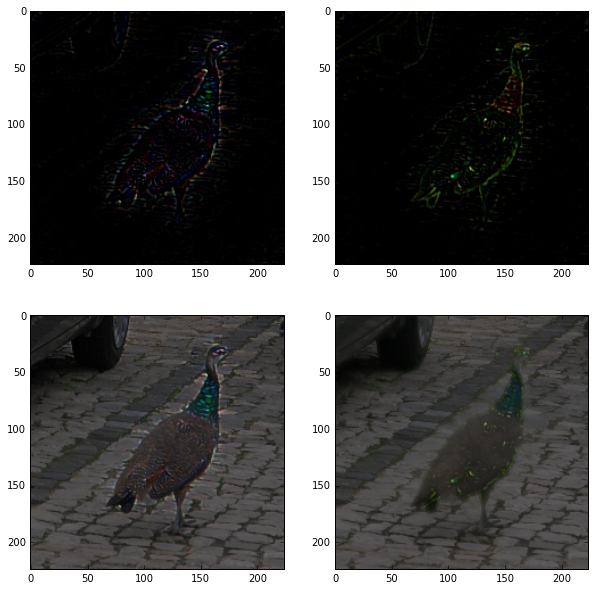

In [8]:
visualise_cls_saliency(peacock, 84)

Predicted class = 985, name = daisy, confidence = 28.12%


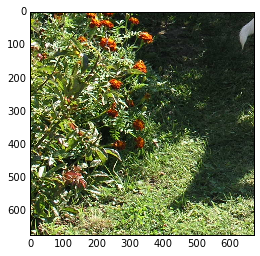

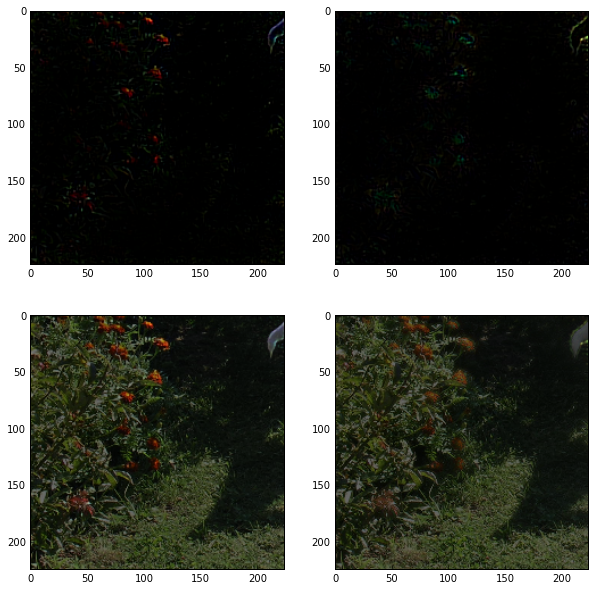

In [9]:
flowers = load_image_block(os.path.join('images', 'P8131065.JPG'), 600, 1300, 224*3, 224*3)
plt.imshow(flowers)

visualise_cls_saliency(flowers)

Predicted class = 738, name = pot, flowerpot, confidence = 68.59%


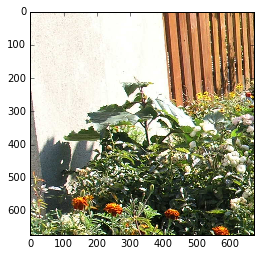

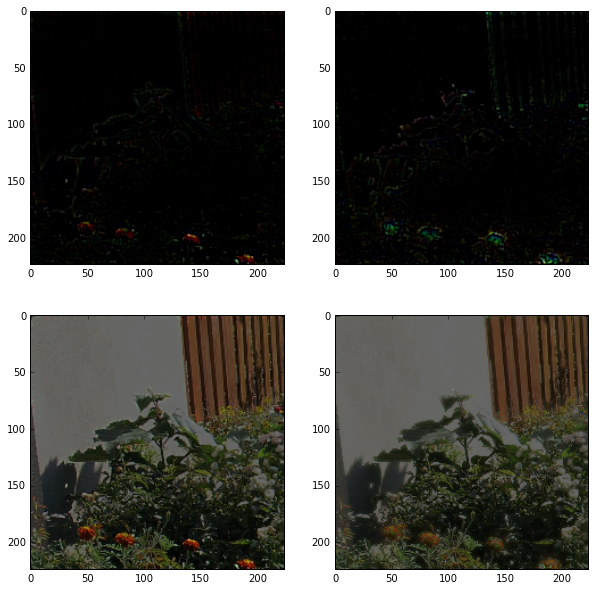

In [10]:
wall_and_flowers = load_image_block(os.path.join('images', 'P8131065.JPG'), 0, 500, 224*3, 224*3)
plt.imshow(wall_and_flowers)

visualise_cls_saliency(wall_and_flowers)

Predicted class = 989, name = hip, rose hip, rosehip, confidence = 38.36%


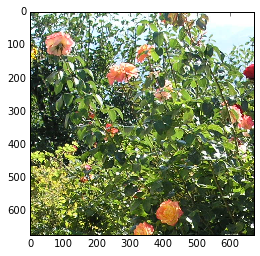

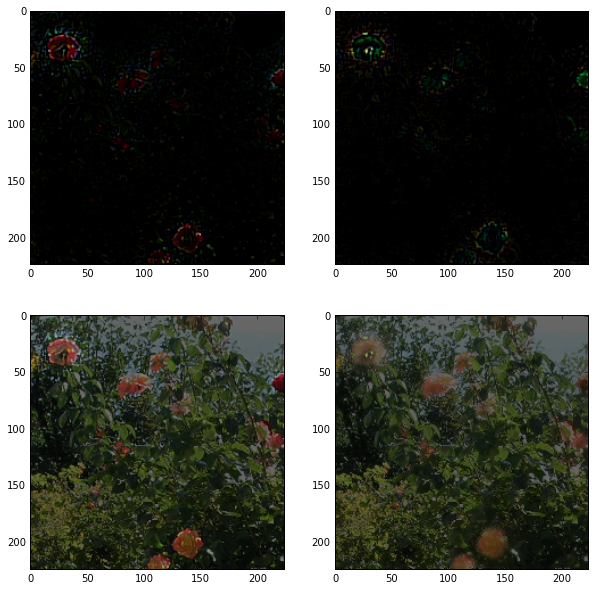

In [11]:
wall_and_flowers = load_image_block(os.path.join('images', 'P8131065.JPG'), 900, 0, 224*3, 224*3)
plt.imshow(wall_and_flowers)

visualise_cls_saliency(wall_and_flowers)

### Visualising saliency at lower levels of the network

It is often informative to visualise pixel level saliency with respect to activations of the convolutional layers of the network.

In the following examples, we visualise saliency with respect to the output at the pooling layers that follow the convolutional layers. It allows us to see how the lower levels of the network detect small simple features - such as colour and gradient - while higher levels detect more complex features.

First, we define functions similar to those before for generating and plotting the saliency images.

In [12]:
# Cache for storing compiled functions
_SALIENCY_FUNCTIONS_BY_LAYER = {}

def compile_low_level_saliency_functions(vgg_model, layer_name='fc8'):
    key = (id(vgg_model), layer_name)
    try:
        return _SALIENCY_FUNCTIONS_BY_LAYER[key]
    except KeyError:
        channel_index = T.iscalar('chn_ndx')
        # Input expression
        inp = vgg_model.network['input'].input_var
        # Expression representing network up to layer `layer_name`
        outp = lasagne.layers.get_output(vgg_model.network[layer_name], deterministic=True)
        # Output at specified channel
        chn_out = outp[:,channel_index]
        
        # Compute threshold expression and produce saliency function with cut-off
        proportion = T.scalar('proportion')
        chn_out_min, chn_out_max = chn_out.min(), chn_out.max()
        prop_threshold = chn_out_min + (chn_out_max - chn_out_min) * proportion
        # Saliency is gradient of output with respect to input
        prop_saliency = theano.grad((chn_out * (chn_out >= prop_threshold)).sum(), wrt=inp)
        prop_fn = theano.function([inp, channel_index, proportion], prop_saliency)

        # Mask out all values but the max
        max_saliency = theano.grad(chn_out.max(), wrt=inp)
        max_fn = theano.function([inp, channel_index], max_saliency)        
        
        # No masking
        all_saliency = theano.grad(chn_out.sum(), wrt=inp)
        all_fn = theano.function([inp, channel_index], all_saliency)        
        
        result = {'proportion': prop_fn, 'max': max_fn, 'all': all_fn}
        _SALIENCY_FUNCTIONS_BY_LAYER[key] = result
        return result
        
        
def visualise_low_level_saliency(img, layer_name, channel_indices, proportion=None, max_mask=False,
                                 show_negative_saliency=False):
    # Prepare the image for use with VGG
    raw_img, img_for_vgg = vgg19_model.prepare_image(img, image_size=224)
    
    # Compile saliency functions fot the specified layer
    sal_fns = compile_low_level_saliency_functions(vgg19_model, layer_name)
    
    if proportion is not None:
        saliency_imgs = [sal_fns['proportion'](img_for_vgg, chn, proportion) for chn in channel_indices]
    elif max_mask:
        saliency_imgs = [sal_fns['max'](img_for_vgg, chn) for chn in channel_indices]
    else:
        saliency_imgs = [sal_fns['all'](img_for_vgg, chn) for chn in channel_indices]
    
    # Extract sample 0, move channel axis to the back and swap BGR to RGb
    saliency_imgs = [saliency[0][::-1].transpose(1, 2, 0) for saliency in saliency_imgs]

    N = len(saliency_imgs)
    num_cols = 3
    if show_negative_saliency:
        num_plots = 1 + N * 2
    else:
        num_plots = 1 + N
    num_rows = num_plots // num_cols + (1 if num_plots % num_cols > 0 else 0)

    # Plot
    plt.figure(figsize=(16,num_rows*5))
    plt.subplot(num_rows,num_cols,1)
    plt.imshow(raw_img)
    
    plot_ndx = 2
    for saliency_image in saliency_imgs:
        plt.subplot(num_rows,num_cols,plot_ndx)
        plt.imshow(raw_img)
        plt.imshow(np.maximum(saliency_image, 0.0) / saliency_image.max(), alpha=0.85)
        plot_ndx += 1
        
        if show_negative_saliency:
            plt.subplot(num_rows,num_cols,plot_ndx)
            plt.imshow(raw_img)
            plt.imshow(np.maximum(-saliency_image, 0.0) / -saliency_image.min(), alpha=0.85)
            plot_ndx += 1

    plt.show()

#### Try it out

In [ ]:
for layer_name in ['pool1', 'pool2', 'pool3', 'pool4', 'pool5']:
    channels = range(11)
    print('----------------------------------------------------')
    print('PIXEL LEVEL SALIENCY OF PEACOCK IMAGE AT LAYER {} for channels {}'.format(layer_name, channels))
    print('----------------------------------------------------')
    visualise_low_level_saliency(peacock, layer_name, channels, proportion=0.5)

In [ ]:
for layer_name in ['pool1', 'pool2', 'pool3', 'pool4', 'pool5']:
    channels = range(11)
    print('----------------------------------------------------')
    print('PIXEL LEVEL SALIENCY OF FLOWERS IMAGE AT LAYER {} for channels {}'.format(layer_name, channels))
    print('----------------------------------------------------')
    visualise_low_level_saliency(flowers, layer_name, channels, proportion=0.5)

In [ ]:
for layer_name in ['pool1', 'pool2', 'pool3', 'pool4', 'pool5']:
    channels = range(11)
    print('----------------------------------------------------')
    print('PIXEL LEVEL SALIENCY OF WALL AND FLOWERS IMAGE AT LAYER {} for channels {}'.format(layer_name, channels))
    print('----------------------------------------------------')
    visualise_low_level_saliency(wall_and_flowers, layer_name, channels, proportion=0.5)